In [1]:
import sys
sys.executable

'/usr/local/anaconda3/envs/ada/bin/python'

In [2]:
%env SPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
%env SPARK_DRIVER=/usr/local/anaconda3/envs/ada/bin/python

env: SPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
env: SPARK_DRIVER=/usr/local/anaconda3/envs/ada/bin/python


In [3]:
# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, BooleanType, ArrayType, StringType

# Profanity check
import profanity_check

# Helpers
import os

In [4]:
conf = pyspark.SparkConf().setMaster("local[*]").setAll([
    ('spark.driver.memory','8G'),
    ('spark.driver.maxResultSize', '8G'),
    ('spark.sql.execution.arrow.pyspark.enabled', True),
    ('spark.sql.execution.arrow.maxRecordsPerBatch', 10000),
    ('spark.local.dir', '/tmp')
])

spark = SparkSession.builder.config(conf=conf).config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2").getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark

:: loading settings :: url = jar:file:/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/MDS/.ivy2/cache
The jars for the packages stored in: /Users/MDS/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c513a1b8-b6bd-40cd-b689-443144e3c616;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.3.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1

In [5]:
DATA_DIR = 'data/'
# DATA_DIR = '/Volumes/Seagate1TB/ada-project/data/'
QUOTEBANK_DATA_DIR = DATA_DIR + 'quotebank_data_raw/'

In [6]:
%%time
dfs = []
for fn in os.listdir(QUOTEBANK_DATA_DIR):
    dfs.append(spark.read.json(QUOTEBANK_DATA_DIR + fn))

CPU times: user 127 ms, sys: 61 ms, total: 188 ms
Wall time: 1min 26s


In [7]:
%%time
df_all = dfs[0]
for df_part in dfs[1:]:
    df_all = df_all.union(df_part)


CPU times: user 2.65 ms, sys: 2.95 ms, total: 5.6 ms
Wall time: 185 ms


In [8]:
# %%time
# df_all.write.parquet(DATA_DIR + "quotebank_data.parquet")

In [9]:
# If quotebank data is already converted to parquet, start from here
# df_all = spark.read.parquet(DATA_DIR + "quotebank_data.parquet")

In [10]:
df = df_all

In [11]:
# Uncomment to run only on a random subset of 10% of the results
# df = df_all.withColumn("random", f.rand()).filter(f.col("random") < 0.1)

In [12]:
# %%time
# df.write.parquet(DATA_DIR + 'randsample.parquet', 'overwrite')

In [13]:
# df = spark.read.parquet(DATA_DIR + 'randsample.parquet')

In [14]:
# Works on an iterator of pandas dataframes and used for mapInPandas()
def compute_profanity(iterator):
    for pdf in iterator:
        yield pd.DataFrame({"quoteID" : pdf.quoteID, "profanity": profanity_check.predict_prob(pdf.quotation)})

In [15]:
dfp = df.select('quoteID', 'quotation').withColumn('profanity', f.lit(0.0))
dfp = dfp.mapInPandas(compute_profanity, schema="quoteID string, profanity float")

In [16]:
# %%time
# dfp.write.parquet(DATA_DIR + "profanity.parquet", "overwrite")

In [17]:
# If profanity scores are already computed, start from here to avoid recomputation
# dfp = spark.read.parquet(DATA_DIR + "profanity.parquet")

In [18]:
# Extract the yyyy-mm part from the date
@f.udf(StringType())
def get_month(date_str):
    return "-".join(date_str.split("-")[:2])

In [19]:
def normalize(key, pdf):
    return pd.DataFrame({"date": [ key[0] ], "mean" : [ pdf.profanity.mean() ], "sem" : [ pdf.profanity.sem() ]})

In [20]:
%%time
d1 = dfp.withColumn('date', get_month(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize, schema="date string, mean double, sem double") \
        .sort("date") \
        .toPandas()

CPU times: user 386 ms, sys: 172 ms, total: 558 ms
Wall time: 8min 31s


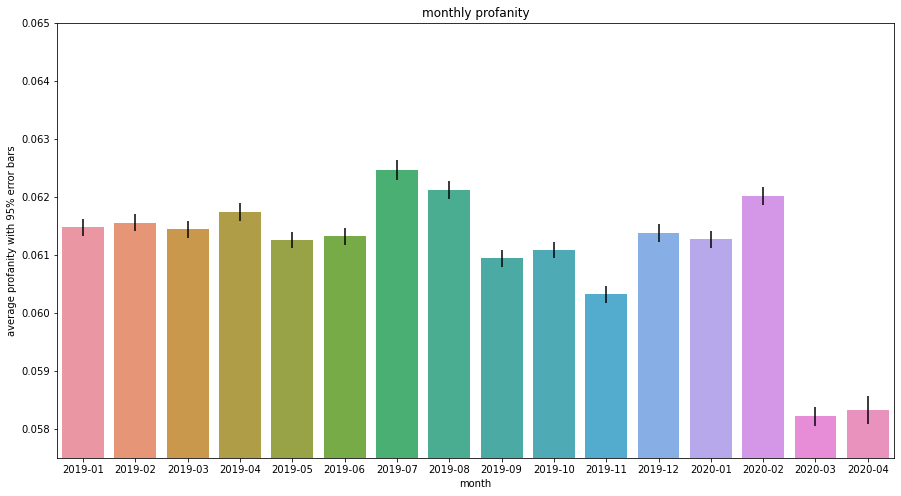

In [21]:
plt.figure(figsize=(15,8))
plt.ylim(0.0575, 0.065)
sns.barplot(x=d1["date"], y=d1["mean"], yerr=1.96*d1["sem"])
plt.xlabel("month")
plt.ylabel("average profanity with 95% error bars")
plt.title("monthly profanity")
plt.show()